# Case: Analisando Reviews da Amazon com IA Generativa 🛒

O comportamento do consumidor está cada vez mais visível por meio das avaliações deixadas em plataformas como a Amazon. Essas reviews trazem insights valiosos sobre a qualidade dos produtos, experiência de compra e eficiência do atendimento. Porém, com milhares de avaliações sendo geradas todos os dias, analisar manualmente esse conteúdo se torna inviável.

Neste case, vamos aplicar **técnicas modernas de Processamento de Linguagem Natural (NLP)** com a **biblioteca pysentimiento da Hugging Face**, focando em um objetivo real do mundo dos negócios: identificar o sentimento (positivo ou negativo) dos clientes com base nos seus comentários.

**🔗Biblioteca:** https://huggingface.co/pysentimiento/bertweet-pt-sentiment

### Sobre a biblioteca 🧠

O modelo base utilizado é o BERTabaporu, um modelo baseado no modelo pré-treinado RoBERTa que foi treinado sobre tweets em português. RoBERTa ("Robustly Optimized BERT Approach") é uma evolução do modelo BERT (Bidirectional Encoder Representations from Transformers), desenvolvido por pesquisadores do Facebook. Assim como o BERT, o RoBERTa é um modelo de linguagem baseado na arquitetura de transformers, que usa mecanismos de autoatenção para interpretar sequências de texto e gerar representações contextuais das palavras em uma sentença.

A RoBERTa, assim como o BERT, é baseada em uma arquitetura transformer do tipo encoder e realiza análise totalmente bidirecional. Isso significa que ela considera o contexto à esquerda e à direita de cada palavra ao gerar sua representação.

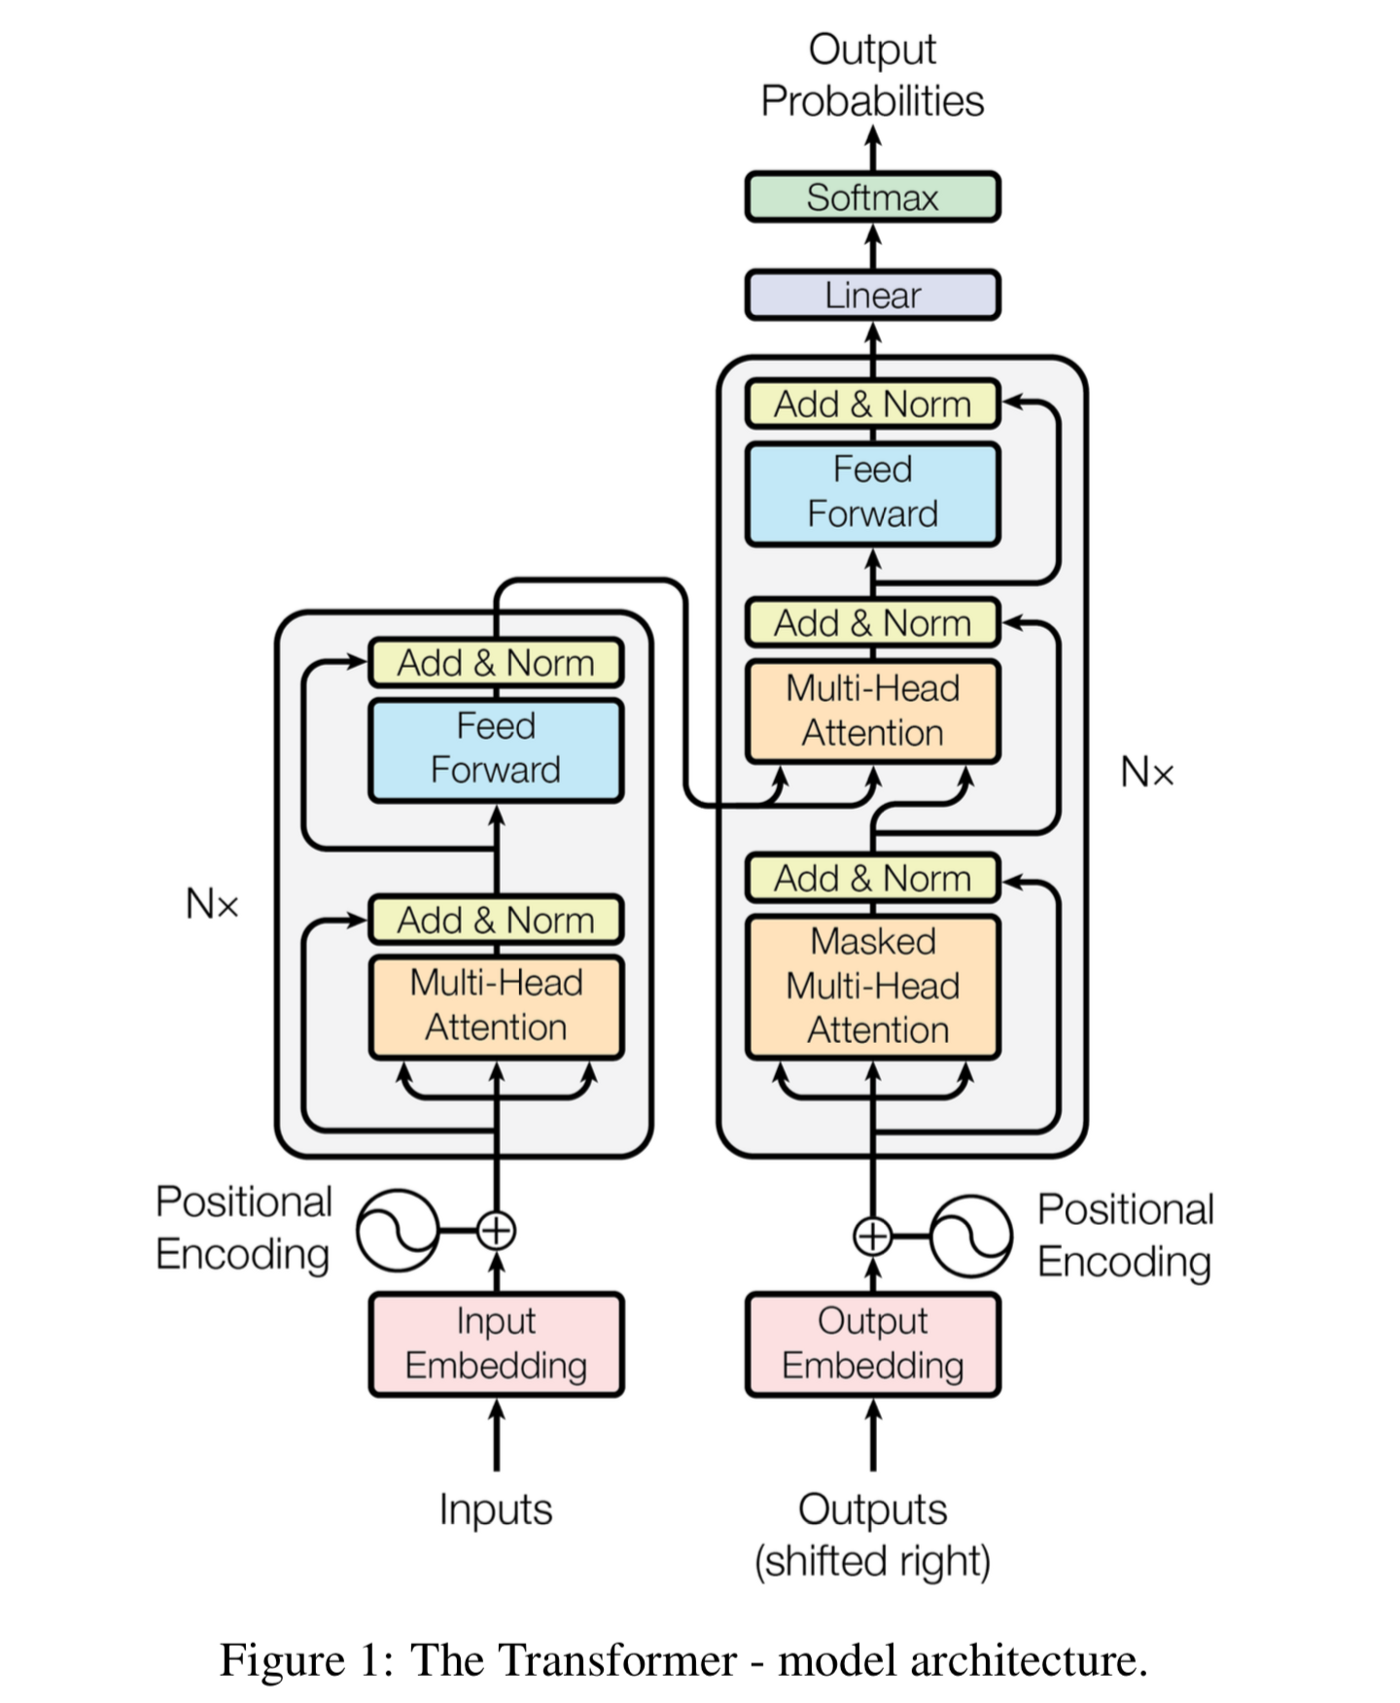

**🎯 Objetivo:**
Criar uma pipeline de processamento de linguagem natural junto com IA Generativa para classificar automaticamente os sentimentos (positivo ou negativo) de comentários de clientes da Amazon.

📚Vamos ver nessa aula:

**Pré-processamento de textos reais**

* Limpeza de dados (remoção de URLs, pontuação, acentos, etc.)

**Eliminação de palavras irrelevantes**

* Vamos utilizar a técnica de remoção de palavras irrelevantes chamada stop words.

**Análise de Sentimento com IA generativa**

* Utilização do modelo multilíngue da Hugging Face com pysentimiento

**Interpretação dos sentimentos e suas probabilidades**

* Construção de uma Pipeline Reutilizável

**Encapsular o fluxo de processamento e classificação**

* Salvar em formato .pkl para reuso e deploy

**Deploy da Solução com Streamlit**

* Construir uma interface simples e funcional

* Permitir que o usuário cole um texto ou envie uma base de comentários

* Retornar o sentimento com probabilidades, em tempo real




✨Explicação do modelo encoder: https://excalidraw.com/#json=jy8e03YCarplspHXa75YO,4NHBn-8zjudU5wDmEDSCSA

### ✨ 1 Passo: Instalando as dependências

In [ ]:
! pip install pysentimiento

In [ ]:
!pip install wordcloud

In [1]:
# libs básicas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# lib para IA Generativa
from transformers import pipeline
from pysentimiento import create_analyzer

# libs para NLP
import re
import unicodedata
import nltk
from nltk.corpus import stopwords

# lib para nuvem de palavras
from wordcloud import WordCloud

# lib para pipeline de modelo + serialização de modelo
from sklearn.pipeline import Pipeline
import pickle

Matplotlib is building the font cache; this may take a moment.
c:\Users\anara\OneDrive\Área de Trabalho\Análise de Sentimento com IA Generativa\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 🎲 2 Passo: Importando a base de dados e realizando e analisando os dados

In [4]:
df = pd.read_csv( r'C:\Users\anara\OneDrive\Área de Trabalho\Análise de Sentimento com IA Generativa\analise_sentimento_com_ia_generativa\data\comments_amazon.csv', sep=',')
df.head()

,Pesquisa,Titulo,Link,Comentario
0,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,A foto fica amarelada quando eu vou fotografar...
1,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,👏🏼👏🏼👏🏼👏🏼👏🏼👏🏼.
2,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Muito bom.
3,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Produto muito bom dei de presente pra meu filh...
4,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Recomendo.


In [5]:
set(df['Pesquisa'])

{'smart tv', 'smartphone'}

In [6]:
df.shape

(933, 4)

In [7]:
df.isnull().sum()

Pesquisa      0
Titulo        0
Link          0
Comentario    0
dtype: int64

### 🧹 3 Passo: Construindo funções para limpar o texto


Por que limpar o texto? Limpar o texto é uma etapa fundamental em qualquer pipeline de NLP porque ajuda o modelo a **entender** melhor os dados e a focar no que realmente importa.

In [9]:
def limpar_texto_completo(texto):
    """
    Limpa o texto, removendo URLs, menções, hashtags, caracteres especiais,
    pontuações, números, espaços extras e acentos, convertendo para lowercase.
    """
    if isinstance(texto, str):
        # Remove URLs
        texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
        # Remove menções (@)
        texto = re.sub(r'@\w+', '', texto)
        # Remove hashtags (#)
        texto = re.sub(r'#\w+', '', texto)
        # Remove caracteres especiais e pontuações, mantendo espaços
        texto = re.sub(r'[^\w\s]', '', texto)
        # Remove números
        texto = re.sub(r'\d+', '', texto)
        # Remove acentos
        texto = ''.join((c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn'))
        # Remove espaços extras
        texto = ' '.join(texto.split())
        return texto.lower()
    return ''

#### O que são as stop words??

Stop words são palavras muito comuns em um idioma que, na maioria das tarefas de NLP, não carregam significado importante por si só e por isso costumam ser removidas durante o pré-processamento dos textos.

Ao remover stop words, acentos e espaços duplicados, você reduz o vocabulário total, o que facilita muitas vezes para o modelo encontrar padrões.

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


{'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'estamos',
 'estar',
 'estas',
 'estava',
 'estavam',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéramos',
 'estivéssemos',
 'estou',
 'está',
 'estávamos',
 'estão',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fui',
 'fôramos',
 'fôssemos',
 'haja',
 'hajam',
 'hajamos',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houveram',
 'houverei',
 'houverem',
 'houveremos',
 'houveria',
 'houveriam',
 'houvermos',
 'houverá',
 'houverão',
 'houverí

In [11]:
def remover_stop_words(texto):
    """
    Remove stop words de um texto.
    """
    if isinstance(texto, str):
        stop_words = set(stopwords.words('portuguese'))
        stop_words.remove('não')
        palavras = texto.split()
        texto_sem_stopwords = [palavra for palavra in palavras if palavra not in stop_words]
        return ' '.join(texto_sem_stopwords)
    return ''


In [12]:
df['comentario_limpo_stop_words'] = df['Comentario'].apply(remover_stop_words) # aplicando a limpeza das stop words

In [13]:
df['comentario_limpo'] = df['comentario_limpo_stop_words'].apply(limpar_texto_completo) # aplicando a limpeza do texto

In [14]:
df.head()

,Pesquisa,Titulo,Link,Comentario,comentario_limpo_stop_words,comentario_limpo
0,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,A foto fica amarelada quando eu vou fotografar...,A foto fica amarelada vou fotografar celular.,a foto fica amarelada vou fotografar celular
1,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,👏🏼👏🏼👏🏼👏🏼👏🏼👏🏼.,👏🏼👏🏼👏🏼👏🏼👏🏼👏🏼.,
2,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Muito bom.,Muito bom.,muito bom
3,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Produto muito bom dei de presente pra meu filh...,Produto bom dei presente pra filho tá amando e...,produto bom dei presente pra filho ta amando e...
4,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Recomendo.,Recomendo.,recomendo


In [15]:
df.shape

(933, 6)

In [16]:
df = df[df['comentario_limpo'].str.strip() != ''] # limpando os espaços em brancos

In [17]:
df.shape

(931, 6)

In [18]:
df.head()

,Pesquisa,Titulo,Link,Comentario,comentario_limpo_stop_words,comentario_limpo
0,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,A foto fica amarelada quando eu vou fotografar...,A foto fica amarelada vou fotografar celular.,a foto fica amarelada vou fotografar celular
2,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Muito bom.,Muito bom.,muito bom
3,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Produto muito bom dei de presente pra meu filh...,Produto bom dei presente pra filho tá amando e...,produto bom dei presente pra filho ta amando e...
4,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Recomendo.,Recomendo.,recomendo
5,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,"Maravilhoso, potência perfeita em questão do p...","Maravilhoso, potência perfeita questão preço!.",maravilhoso potencia perfeita questao preco


### 🤖 4 Passo: Utilizando o modelo de IA Generativa para calssificação do texto


In [19]:
# Criar o analisador de sentimento
analyzer = create_analyzer(task="sentiment", lang="pt")

c:\Users\anara\OneDrive\Área de Trabalho\Análise de Sentimento com IA Generativa\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anara\.cache\huggingface\hub\models--pysentimiento--bertweet-pt-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the '

In [20]:
# Vamos criar uma função para realizar a predição da classe do modelo em positivo ou negativo.
# Para as palavras neutras, vamos usar um limiar de 0.55 para analisar entre positivo ou negativo e escolher qual classe ganha.

def classificar_sentimento(texto, threshold=0.55):
    resultado = analyzer.predict(texto)
    probas = resultado.probas

    if resultado.output == "POS":
        return pd.Series(["positivo", round(probas["POS"], 3)])
    elif resultado.output == "NEG":
        return pd.Series(["negativo", round(probas["NEG"], 3)])
    else:
        # Se for neutro, compara POS e NEG e decide pela maior, se confiável
        if probas["POS"] >= threshold:
            return pd.Series(["positivo", round(probas["POS"], 3)])
        elif probas["NEG"] >= threshold:
            return pd.Series(["negativo", round(probas["NEG"], 3)])
        else:
            # Caso incerto: identifica tendência
            tendencia = "positiva" if probas["POS"] > probas["NEG"] else "negativa"
            prob_max = max(round(probas["POS"], 3), round(probas["NEG"], 3))
            return pd.Series([f"incerto (tendência {tendencia})", prob_max])



In [21]:
df[['sentimento', 'probabilidade']] = df['comentario_limpo'].apply(classificar_sentimento)

In [22]:
df.head()

,Pesquisa,Titulo,Link,Comentario,comentario_limpo_stop_words,comentario_limpo,sentimento,probabilidade
0,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,A foto fica amarelada quando eu vou fotografar...,A foto fica amarelada vou fotografar celular.,a foto fica amarelada vou fotografar celular,incerto (tendência negativa),0.345
2,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Muito bom.,Muito bom.,muito bom,positivo,0.993
3,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Produto muito bom dei de presente pra meu filh...,Produto bom dei presente pra filho tá amando e...,produto bom dei presente pra filho ta amando e...,positivo,0.982
4,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,Recomendo.,Recomendo.,recomendo,positivo,0.982
5,smartphone,Smartphone Samsung Galaxy A14 Dual 6.6 128gb P...,https://produto.mercadolivre.com.br/MLB-331518...,"Maravilhoso, potência perfeita em questão do p...","Maravilhoso, potência perfeita questão preço!.",maravilhoso potencia perfeita questao preco,positivo,0.990


### 🔎 5 Passo: Avaliando os resultados


C:\Users\anara\AppData\Local\Temp\ipykernel_26996\2401218206.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=volumetria_sentimento.index, y=volumetria_sentimento.values, palette='viridis')


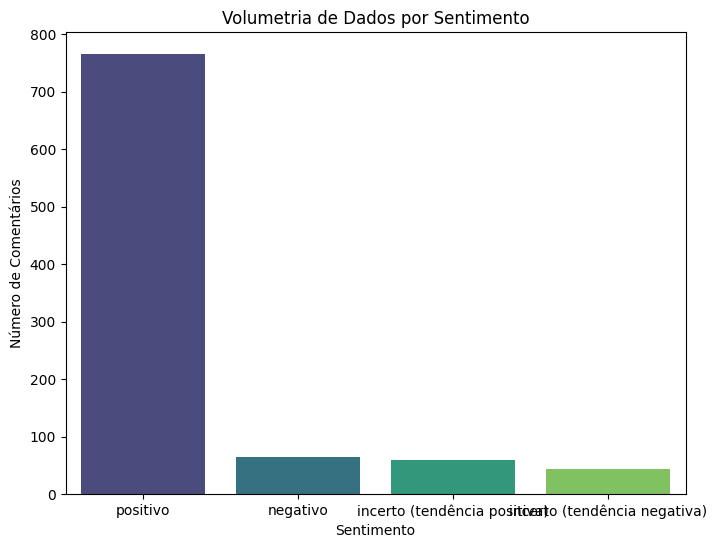

In [23]:
volumetria_sentimento = df['sentimento'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=volumetria_sentimento.index, y=volumetria_sentimento.values, palette='viridis')
plt.title('Volumetria de Dados por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Número de Comentários')
plt.show()


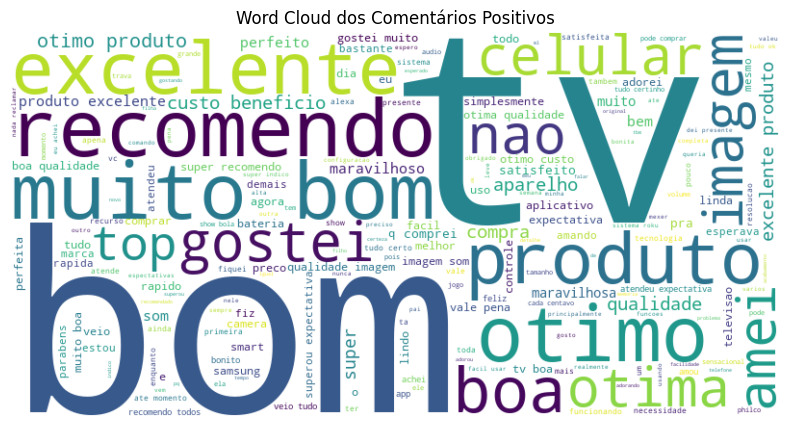

In [24]:
# Filtrar apenas os comentários classificados como "positivo"
df_positivo = df[df['sentimento'] == 'positivo']

texto_positivo = " ".join(review for review in df_positivo['comentario_limpo'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_positivo)

# Exibir a WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud dos Comentários Positivos')
plt.show()

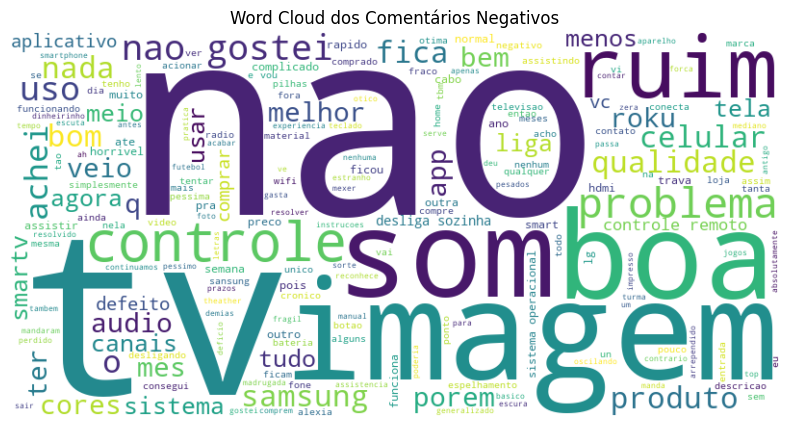

In [25]:
# Filtrar apenas os comentários classificados como "negativo"
df_negativo = df[df['sentimento'] == 'negativo']

texto_negativo = " ".join(review for review in df_negativo['comentario_limpo'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_negativo)

# Exibir a WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud dos Comentários Negativos')
plt.show()

In [26]:
df_negativo[['Comentario', 'sentimento', 'probabilidade']].sort_values(by='probabilidade', ascending=False)

,Comentario,sentimento,probabilidade
463,Som ruim.,negativo,0.993
574,Não gostei.,negativo,0.993
616,"Não gostei do sistema roku, meio travado e não...",negativo,0.991
216,Trava muito não gostei muito ruim.,negativo,0.990
494,Com menos de 1 mês não liga só pisca horrível ...,negativo,0.990
...,...,...,...
600,Tv boa so achei o som um pouco baixo.,negativo,0.524
752,Após 6 mês de uso apresentado defeito desliga ...,negativo,0.499
469,"Imagem espetacular, porém a qualidade do som d...",negativo,0.489
626,Não tem os aplicativos que eu queria google e ...,negativo,0.485


In [27]:
# Filtrar os comentários negativos que contêm a palavra "boa" e que foram classificados como "negativo"
df_negativos_com_boa_filtrado = df[(df['sentimento'] == 'negativo') & (df['comentario_limpo'].str.contains('boa', na=False))].copy()

pd.set_option('display.max_colwidth', None) # Exibe até 1000 caracteres por célula
df_negativos_com_boa_filtrado[['Comentario', 'sentimento', 'probabilidade']]

,Comentario,sentimento,probabilidade
361,Tv muito boa porem tem un problema mesmo com cabo otico a tv reconhece o home theather antigo como 2. 1 e nao 5. 1 mas e um problema generalizado da lg.,negativo,0.593
381,"Boa tv, ótima imagem, som mediano.\r\nMaterial do controle muito frágil, não gostei do controle.\r\nAté agora nenhum problema com a tv.",negativo,0.981
434,"Tv muito boa pelo preço cobrado. O som não é ruim, mas tbm não se destaca em nada.",negativo,0.892
557,"A tv smart muito boa, sistema operacional roku é bom, só o único problema é o som muito fraco, tenho uma outra tv da mesma marca e tamanho e não é smart e tem o som melhor.",negativo,0.885
561,"A tv é muito boa,o único ponto negativo nela é que ela não tem navegador de internet,não tem como acessar google,a roku tv é um sistema fechado.",negativo,0.925
563,O preço foi muito bom mais a imagem da tv e muito ruim para assistir os canais da minha região mais para a internet ela e muito boa ir faltou um pé da tv.,negativo,0.978
567,"A tv com sistema roku é até bom, mas é incompleto. Não tem cromecast, depende do celular pra usar o fone. E ainda falta alguns aplicativos. Fora isso é boa pelo preço!.",negativo,0.945
600,Tv boa so achei o som um pouco baixo.,negativo,0.524
628,"Eu achei muito boa a tv porém esse sistema roku achei complicado para cadastrar, até desisti, confuso.",negativo,0.935
738,A tv é boa mas colocaram colante na tela é manchou não sei oque fazer.,negativo,0.962


### ⚙️ 6 Passo: Criando a pipeline do modelo

In [28]:
class SentimentPipeline:
    def __init__(self):
        pass

    def processar_texto(self, texto):
        texto_limpo = limpar_texto_completo(texto)
        texto_sem_stop = remover_stop_words(texto_limpo)
        sentimento, prob = classificar_sentimento(texto_sem_stop)
        return {
            "texto_original": texto,
            "texto_processado": texto_sem_stop,
            "sentimento": sentimento,
            "probabilidade": prob
        }

    def processar_dataframe(self, df, coluna="comentario_limpo"):
        resultados = df[coluna].apply(self.processar_texto)
        return pd.DataFrame(resultados.tolist())



In [29]:
pipeline = SentimentPipeline()

with open("sentiment_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [30]:
# Carregar pipeline salva
with open("sentiment_pipeline.pkl", "rb") as f:
    pipeline = pickle.load(f)

# Exemplo de uso
df_teste = pd.DataFrame({
    "comentario_limpo": [
        "Entrega atrasou, não gostei.",
        "Tudo perfeito, produto maravilhoso!",
        "Ok.",
        "Não recomendo de forma alguma",
        "Não gostei",
        "Entrega veio atrasada, não sei o que pode ter acontecido, mas além de tudo a tela veio quebrada"
    ]
})

df_teste.head(6)


,comentario_limpo
0,"Entrega atrasou, não gostei."
1,"Tudo perfeito, produto maravilhoso!"
2,Ok.
3,Não recomendo de forma alguma
4,Não gostei
5,"Entrega veio atrasada, não sei o que pode ter acontecido, mas além de tudo a tela veio quebrada"


In [ ]:
resultado = pipeline.processar_dataframe(df_teste)
resultado

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,texto_original,texto_processado,sentimento,probabilidade
0,"Entrega atrasou, não gostei.",entrega atrasou nao gostei,negativo,0.989
1,"Tudo perfeito, produto maravilhoso!",tudo perfeito produto maravilhoso,positivo,0.993
2,Ok.,ok,incerto,0.166
3,Não recomendo de forma alguma,nao recomendo forma alguma,negativo,0.986
4,Não gostei,nao gostei,negativo,0.993
5,"Entrega veio atrasada, não sei o que pode ter acontecido, mas além de tudo a tela veio quebrada",entrega veio atrasada nao sei pode ter acontecido alem tudo tela veio quebrada,negativo,0.872
